In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras as ke

import os

from tensorflow.keras.layers import Dense, BatchNormalization


import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.layers import Dense, BatchNormalization

import random
from itertools import permutations

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR

%matplotlib inline

In [5]:
# Read the regrouped data from group 1 to 9; drop the gender column
#file_path_train = './normal_female/train.csv'
#file_path_test =  './normal_female/valid.csv'

file_path_train = './normal_AllGender/train.csv'
#file_path_test =  './normal_AllGender/valid.csv'
file_path_test =  './normal_AllGender/test.csv'

df_train = pd.read_csv(file_path_train, sep = ',')
#df_train = df_train.drop(['Gender'], axis=1)
X_train = df_train.drop(['Group'], axis=1)
y_train = df_train['Group']

df_test = pd.read_csv(file_path_test, sep = ',')
#df_test = df_test.drop(['Gender'], axis=1)
X_test = df_test.drop(['Group'], axis=1)
y_test = df_test['Group']
X_test

,QRS_Duration__ms_C,R_T_Axis_deviation,Gender,Ventricular_Rate_C,P_Axis_C,R_Axis_C,T_Axis_C,QTc_Calculation_C,QTc_Bazett_C,QTc_Friderica_C,...,P_Peak_Amplitude_C_aVR,Q_Peak_Amplitude_C_aVR,R_Peak_Amplitude_C_aVR,S_Peak_Amplitude_C_aVR,T_Peak_Amplitude_C_aVR,Q_Area_C_aVR,R_Area_C_aVR,S_Area_C_aVR,T_Area_C_aVR,Summated_QRS_integral_aVR
0,96.0,35.0,0,70.0,45.0,93.0,58.0,427.0,135,417,...,-78.0,712.0,390.0,0.0,-302.0,616.0,616.0,0.0,-1652.0,1232.0
1,88.0,16.0,1,106.0,28.0,65.0,49.0,448.0,142,409,...,-112.0,0.0,126.0,1230.0,-258.0,0.0,76.0,1017.0,-1354.0,1093.0
2,92.0,-85.0,0,123.0,39.0,-12.0,73.0,401.0,127,356,...,-126.0,1108.0,380.0,0.0,-219.0,1084.0,305.0,0.0,-1034.0,1389.0
3,58.0,70.0,0,170.0,67.0,82.0,12.0,433.0,137,365,...,-131.0,800.0,634.0,0.0,-151.0,481.0,466.0,0.0,-648.0,947.0
4,98.0,50.0,0,59.0,32.0,69.0,19.0,413.0,131,416,...,-107.0,644.0,278.0,0.0,-278.0,683.0,400.0,0.0,-1622.0,1083.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,96.0,21.0,0,116.0,68.0,81.0,60.0,444.0,141,399,...,-131.0,0.0,92.0,971.0,-239.0,0.0,45.0,812.0,-1082.0,857.0
6014,84.0,4.0,0,79.0,53.0,62.0,58.0,435.0,138,416,...,-107.0,834.0,200.0,0.0,-234.0,938.0,148.0,0.0,-1033.0,1086.0
6015,70.0,13.0,0,94.0,58.0,51.0,38.0,446.0,141,414,...,-131.0,903.0,146.0,0.0,-209.0,870.0,65.0,0.0,-1462.0,935.0
6016,90.0,29.0,0,76.0,70.0,98.0,69.0,446.0,138,420,...,-122.0,678.0,307.0,39.0,-405.0,739.0,256.0,19.0,-2618.0,1014.0


In [6]:
epochs = 100
batch_size = 256
logging_step = 5

z_dim = 50
image_shape = (13,13,1)#(21, 8,1)
hidden_layer_size = 512

relu_leak = 0.2
init_lr = 0.00001

initializer = ke.initializers.RandomNormal(stddev=0.02)
regularizer = ke.regularizers.l2(2.5e-5)
optimizer = ke.optimizers.Adam(learning_rate=init_lr, beta_1=0.5)

In [7]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data using the scaler
X_train = scaler.transform(X_train).reshape(-1, image_shape[0], image_shape[1], image_shape[2])
X_test = scaler.transform(X_test).reshape(-1, image_shape[0], image_shape[1], image_shape[2])


In [8]:
from sklearn.preprocessing import LabelBinarizer

# Initialize the LabelBinarizer
label_binarizer = LabelBinarizer()

# Fit and transform the labels
y_test = label_binarizer.fit_transform(y_test)


# Fit and transform the labels
y_train = label_binarizer.fit_transform(y_train)



In [9]:
models_prefix = 'ResnetmodelsageclfAll/'
images_prefix = 'ResnetimagesageclfAll/'

if not os.path.exists(models_prefix):
  os.mkdir(models_prefix)

if not os.path.exists(images_prefix):
  os.mkdir(images_prefix)

In [10]:
def create_resnet_model(input_shape, num_classes):
    # Define the input layer
    inputs = ke.Input(shape=input_shape)

    # Initial convolutional layer
    x = ke.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = ke.layers.BatchNormalization()(x)
    x = ke.layers.Activation('relu')(x)
    x = ke.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=32, blocks=2, strides=(1, 1))
    x = residual_block(x, filters=64, blocks=2, strides=(2, 2))

    # Global average pooling and dense layer for classification
    x = ke.layers.GlobalAveragePooling2D()(x)
    x = ke.layers.Dense(hidden_layer_size, kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
    x = ke.layers.BatchNormalization()(x)
    x = ke.layers.LeakyReLU(relu_leak)(x)
    x = ke.layers.Dense(num_classes, activation='softmax', kernel_initializer=initializer)(x)

    # Create the model
    model = ke.Model(inputs=inputs, outputs=x)
    
    return model


In [11]:

def residual_block(inputs, filters, blocks, strides):
    x = ke.layers.Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(inputs)
    x = ke.layers.BatchNormalization()(x)
    x = ke.layers.Activation('relu')(x)

    for _ in range(blocks - 1):
        shortcut = x
        x = ke.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
        x = ke.layers.BatchNormalization()(x)
        x = ke.layers.Activation('relu')(x)
        x = ke.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
        x = ke.layers.BatchNormalization()(x)
        x = ke.layers.Add()([x, shortcut])
        x = ke.layers.Activation('relu')(x)

    return x




In [12]:
# Create the ResNet model for classification
model = create_resnet_model(input_shape=image_shape, num_classes=9)

2023-07-19 16:34:00.329991: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 16:34:00.333417: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [20]:

compile_model = 0

if compile_model:
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test)
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss:", loss)
    print("Test Accuracy:", accuracy)

In [23]:
import os
save_model = 1

if save_model:
    
    # Create the directory if it doesn't exist
    if not os.path.exists(models_prefix):
        os.makedirs(models_prefix)

    # Save the model's architecture in a JSON file
    model_json = model.to_json()
    with open(os.path.join(models_prefix, 'model_architecture.json'), 'w') as json_file:
        json_file.write(model_json)

    # Save the model's weights in an HDF5 file
    #model.save_weights(os.path.join(models_prefix, 'model_weights.h5'))

In [24]:
from tensorflow.keras.models import model_from_json

# Load the model architecture from the JSON file
with open(os.path.join(models_prefix, 'model_architecture.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load the model weights from the HDF5 file
loaded_model.load_weights(os.path.join(models_prefix, 'model_weights.h5'))

# Compile the loaded model
loaded_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
gender_test = X_test.reshape(-1,169)[:,2]

In [40]:
y_test_copy = y_test

Accuracy: 0.555167829843802


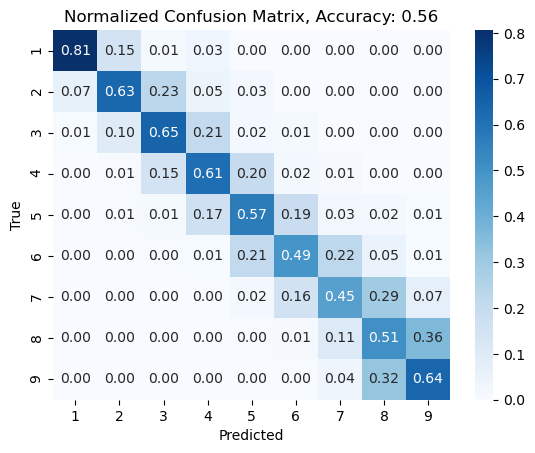

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use the loaded model to make predictions on the test set

#y_test = np.argmax(y_test, axis=1) 



# Use the loaded model to make predictions on the test set
y_pred = loaded_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


y_test = y_test_copy#[gender_test == 1]
#y_pred_classes = y_pred_classes[gender_test == 1]



labels = np.unique(y_test) + 1


# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred_classes)

# Print the accuracy score
print('Accuracy:', accuracy)




# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Calculate normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]





# Visualize the confusion matrix
#plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix, Accuracy: ' + "{:.2f}".format(accuracy))

# Save the graph as a high-resolution TIFF image
name = images_prefix + 'ResnetConf_ageAll' 
plt.savefig(name + '.tiff', dpi=300)


In [ ]:





# Plot the regression results
plt.scatter(y_test, np.max(y_pred,1), c=y_test, cmap='viridis', alpha=0.5)
plt.colorbar(label='Category')
plt.ylabel('Predicted Value')
plt.xlabel('Group')
plt.title('Regression Results')# with Category Colors\nMAE: {:.2f}  MSE: {:.2f}  R2 Score: {:.2f}'.format(mae, mse, r2))



# Save the graph as a high-resolution TIFF image
name = images_prefix + 'ResnetRegression' 
plt.savefig(name + '.tiff', dpi=300)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Combine the data into a DataFrame
data = pd.DataFrame({'y_test': y_test, 'y_pred': np.max(y_pred, 1)})

# Set up the Seaborn catplot
custom_palette = sns.color_palette('viridis', n_colors=len(data['y_test'].unique()), desat=1)
g = sns.catplot(data=data, x='y_test', y='y_pred', kind='swarm', palette=custom_palette, alpha=1)

# Set plot labels and title
g.set_axis_labels('Group', 'Predicted Value')
g.fig.suptitle('Regression Results')

# Save the graph as a high-resolution TIFF image
name = images_prefix + 'ResnetRegression'
g.savefig(name + '.tiff', dpi=300)
